In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy.stats import wilcoxon
import pickle

# General Purpose Functions

In [2]:
def get_main_figure_info(adf,ametric,color_dict):
    
    # sort so all samples are ordered the same way for each metric
    adf = adf.sort_values(by=['SampleNum'])
    
    # get the train and test data type
    Trndata = adf['Train-Data'].unique()[0]
    Tstdata = adf['Test-Data'].unique()[0]
    
    # get the methods
    methods = adf['Model'].unique()
    
    # make a dict that will hold some info
    plot_info_dict = {}
    for amethod in methods:
        plot_info_dict[amethod] = {}
        
    # get the values as a numpy array for every method
    are_there_nans = False
    for amethod in methods:
        vals = adf[adf['Model']==amethod]['Value'].to_numpy()
        if np.count_nonzero(np.isnan(vals)) > 0:
            inds = np.argwhere(np.isnan(vals))
            print('For %s there were %i nan values'%(amethod,len(inds)))
            # here set to some very low value close to zero to not mess up calculation
            if ametric in ['spearman','pearson']:
                vals[inds] = 1e-18
                print('The nan values were replaced with zero')
        plot_info_dict[amethod]['All_Values'] = vals   
        
    # get median values and get them as a ranked list
    med_meth_val = []
    med_meth_name = []
    for amethod in methods:
        med_val_tmp = np.median(plot_info_dict[amethod]['All_Values'])
        med_meth_name.append(amethod)
        med_meth_val.append(med_val_tmp)
        plot_info_dict[amethod]['Median'] = med_val_tmp
    # get the final method order
    med_meth_val = np.array(med_meth_val)
    med_meth_name = np.array(med_meth_name)
    med_args = np.argsort(med_meth_val)
    final_method_order = med_meth_name[med_args]
    # get the colors
    my_colors = np.array([color_dict[item] for item in final_method_order])
    if ametric in ['spearman','pearson']:
        final_method_order = final_method_order[::-1]
        my_colors = my_colors[::-1]
    
    # get the number of times SL was better/or worse than the other methods
    for amethod in methods:
        if amethod == 'SampleLASSO':
            plot_info_dict[amethod]['Percent_Better'] = 'N/A'
        else:
            percent_better = np.sum(plot_info_dict[amethod]['All_Values'] > plot_info_dict['SampleLASSO']['All_Values']) / len(plot_info_dict['SampleLASSO']['All_Values'])
            if ametric in ['spearman','pearson']:
                percent_better = 1 - percent_better
            elif ametric in ['cvrmse','mae']:
                pass
            else:
                print('Unknown metric')
                break
            plot_info_dict[amethod]['Percent_Better'] = percent_better
            
    # get the ratio of median values 
    for amethod in methods:
        if amethod == 'SampleLASSO':
            plot_info_dict[amethod]['Effect_Size'] = 'N/A'
        else:
            effect_size = np.log2(plot_info_dict[amethod]['Median'] / plot_info_dict['SampleLASSO']['Median'])
            if ametric in ['spearman','pearson']:
                effect_size  = -1 * effect_size 
            elif ametric in ['cvrmse','mae']:
                pass
            else:
                print('Unknown metric')
                break
            plot_info_dict[amethod]['Effect_Size'] = effect_size 
            
    # get the p-value of the Wilcoxin test
    for amethod in methods:
        if amethod == 'SampleLASSO':
            plot_info_dict[amethod]['P-Value'] = 'N/A'
        else:
            wstat, pval = wilcoxon(plot_info_dict[amethod]['All_Values'],plot_info_dict['SampleLASSO']['All_Values'])
            plot_info_dict[amethod]['P-Value'] = pval
            
    
    
    print('Some extra information about plot for Trn-%s and Tst-%s and Metric-%s'%(Trndata,Tstdata,ametric))
    for amethod in final_method_order:
        print('The median value for %s is'%amethod,plot_info_dict[amethod]['Median'])
    for amethod in final_method_order:
        print('The effect size for SampleLASSO against %s is'%amethod,plot_info_dict[amethod]['Effect_Size'])
    for amethod in final_method_order:
        print('The percentage of times SampleLASSO is better than %s is'%amethod,plot_info_dict[amethod]['Percent_Better'])
    for amethod in final_method_order:
        print('The effect size for SampleLASSO against %s is'%amethod,plot_info_dict[amethod]['P-Value'])
    print()
    print()
    
    return final_method_order, my_colors, plot_info_dict
    

def make_name_dict(afolder):
    name_dict = {}
    afolder_end = afolder.strip().split('/')[-1]
    folder_split = afolder_end.split('__')
    for item in folder_split:
        akey, avalue = item.split('--')
        name_dict[akey] = avalue
    return name_dict

def subset_results(akey,results_dict,aplat,aGS):
    df_tmp = results_dict[akey]
    df_tmp = df_tmp[df_tmp['Train-Data']==aplat[0]]
    df_tmp = df_tmp[df_tmp['Test-Data']==aplat[1]]
    df_tmp = df_tmp[df_tmp['GeneSplit']==aGS]
    return df_tmp

def make_array(df_tmp,HPs):
    arr_tmp = []
    for aHP in HPs:
        vec_tmp = df_tmp[df_tmp['HyperParameter']==aHP]['Value'].tolist()
        arr_tmp.append(vec_tmp)
    arr_tmp = np.array(arr_tmp)
    return arr_tmp

def find_best_HP(arr_tmp,HPs):
    min_ind = np.argmin(np.median(arr_tmp,axis=1),axis=0)
    best_HP = HPs[min_ind]
    if min_ind == 0:
        print('Already lowest')
        return best_HP
    else:
        zstat, pval = wilcoxon(x=arr_tmp[min_ind,:],y=arr_tmp[min_ind-1,:])
        print('Pvalue of next least complex HP is',pval)
        return best_HP

# Load result tsv files

In [3]:
HPresults_KNN = pd.read_csv('../results/HPtuning-results-KNN-NRMSE.tsv',sep='\t')
HPresults_Lasso = pd.read_csv('../results/HPtuning-results-Lasso-NRMSE.tsv',sep='\t')
HPresults_DNN = pd.read_csv('../results/HPtuning-results-DNN-NRMSE.tsv',sep='\t')
HPresults = pd.concat([HPresults_KNN,HPresults_Lasso,HPresults_DNN])
with open('../results/HPtuning-Best-HPs-NRMSE.pickle', 'rb') as handle:
    best_hp_list = pickle.load(handle)
best_df = pd.read_csv('../results/BestEvals-NRMSE.tsv',sep='\t')
SM_best_df = pd.read_csv('../results/BestEvals-Spearman-MAE.tsv',sep='\t')
results_data = np.load('../results/Beta-Analysis-Heatmap-Data.npy')
results_annot = np.load('../results/Beta-Analysis-Heatmap-Annotations.npy')
results_boxplot_df = pd.read_csv('../results/Beta-Analysis-Boxplot-Data.tsv',sep='\t')
DNN_Loss = pd.read_csv('../results/DNN-Loss.tsv',sep='\t')

# Make HP tuning figures

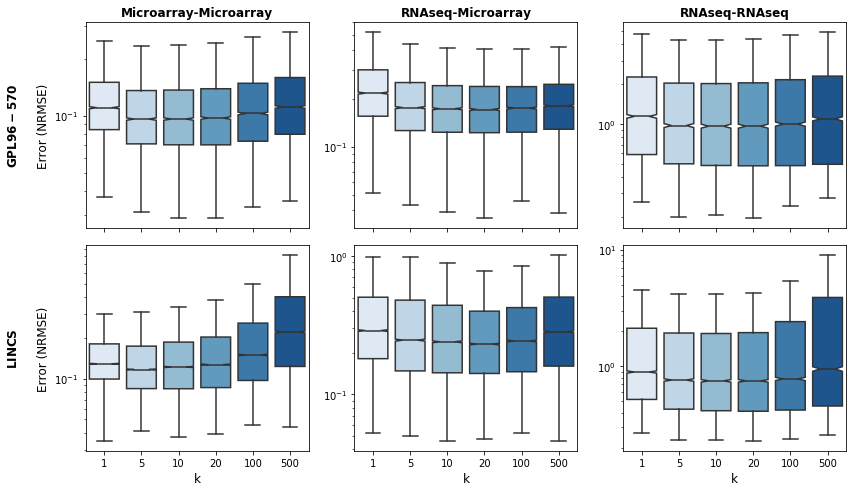

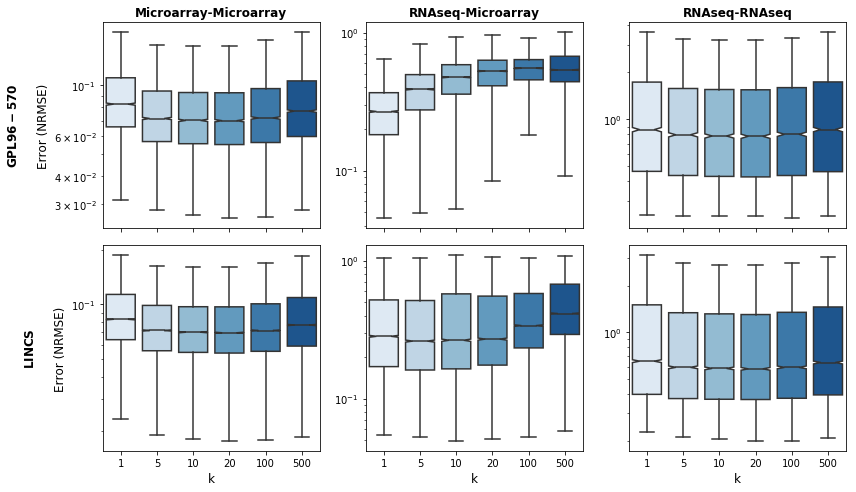

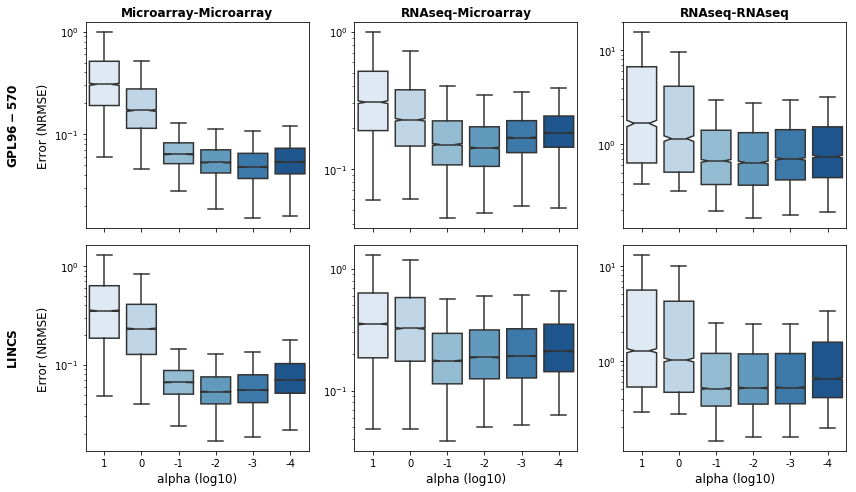

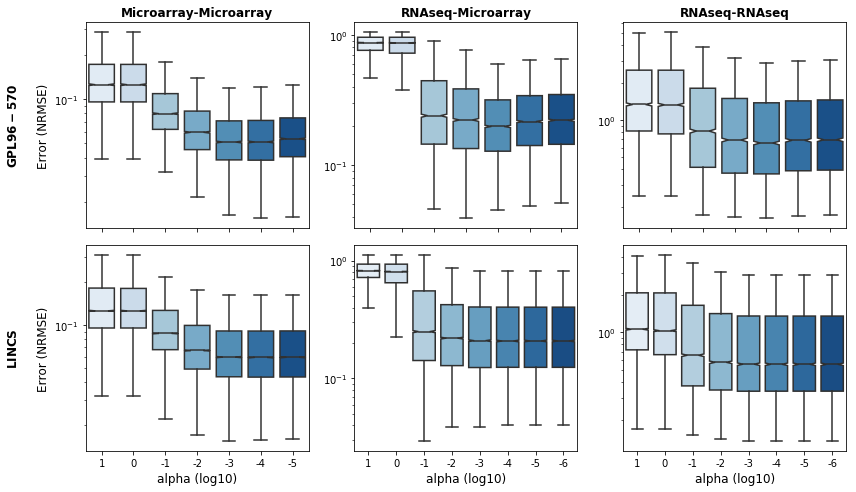

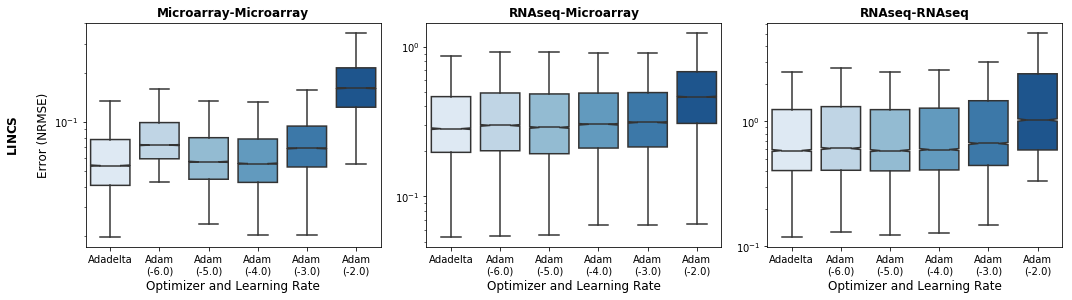

In [4]:
HPtuning_metric_name = 'NRMSE'
for amodel in ['GeneKNN','SampleKNN','SampleLasso','GeneLasso','GeneDNN']:
    
    if amodel != 'GeneDNN':
    
        dfresults = HPresults[HPresults['Model']==amodel]
        fig, ax = plt.subplots(2,3,figsize=(12,7))
        df_tmp = dfresults[dfresults['Split']=='Val']
        for idx1, apltfm in enumerate([['Microarray','Microarray'],['RNAseq','Microarray'],['RNAseq','RNAseq']]):
            for idx2, avalid in enumerate(['GPL96-570','LINCS']):
                df_tmp2 = df_tmp[(df_tmp['Train-Data']==apltfm[0]) & (df_tmp['Test-Data']==apltfm[1])]
                df_tmp2 = df_tmp2[df_tmp2['GeneSplit']==avalid]
                if df_tmp2.shape[0] == 0:
                    pass
                else:
                    if 'KNN' in amodel:
                        hps = np.array([int(item) for item in df_tmp2['HyperParameter'].unique()])
                        hps = np.sort(hps)
                        hps_label = [int(item) for item in hps]
                    else:
                        hps = np.array([float(item) for item in df_tmp2['HyperParameter'].unique()])
                        hps = np.flip(np.sort(hps)) 
                        hps_label = [int(np.log10(item)) for item in hps]
                    sns.boxplot(data=df_tmp2, x='HyperParameter',y='Value',
                                ax=ax[idx2,idx1],showfliers=False,notch=True,
                                palette='Blues',order=hps)
                    ax[idx2,idx1].set_yscale('log')
                    ax[idx2,idx1].set_ylabel('')
                    ax[idx2,idx1].set_xticklabels(hps_label)
                    if 'KNN' in amodel:
                        ax[idx2,idx1].set_xlabel('k',fontsize=12)
                    else:
                        ax[idx2,idx1].set_xlabel('alpha (log10)',fontsize=12)
        ax[0,0].set_ylabel(r'$\bf{' + str('GPL96-570') + '}$' + '\n\nError (%s)'%HPtuning_metric_name,fontsize=12)
        ax[1,0].set_ylabel(r'$\bf{' + str('LINCS') + '}$' + '\n\nError (%s)'%HPtuning_metric_name,fontsize=12)
        ax[0,0].set_title('Microarray-Microarray',fontweight='bold')
        ax[0,1].set_title('RNAseq-Microarray',fontweight='bold') 
        ax[0,2].set_title('RNAseq-RNAseq',fontweight='bold')
        for ax_tmp in [ax[0,0],ax[0,1],ax[0,2]]:
            ax_tmp.set_xlabel('')
            ax_tmp.set_xticklabels('')
        plt.tight_layout()
        fig.subplots_adjust(top=0.95,bottom=0.1)
        plt.show()
    
    elif amodel == 'GeneDNN':
        
        fig, ax = plt.subplots(1,3,figsize=(15,4))
        dfresults = HPresults[HPresults['Model']==amodel]
        df_tmp = dfresults[dfresults['Split']=='Val']
        df_tmp = df_tmp[df_tmp['GeneSplit']=='LINCS']
        for idx1, apltfm in enumerate([['Microarray','Microarray'],['RNAseq','Microarray'],['RNAseq','RNAseq']]):
            df_tmp2 = df_tmp[(df_tmp['Train-Data']==apltfm[0]) & (df_tmp['Test-Data']==apltfm[1])]
            if df_tmp2.shape[0] == 0:
                pass
            else:
                hps = list(np.sort(df_tmp2['HyperParameter'].unique()))
                hps = [hps[0]] + hps[1:][::-1]
                sns.boxplot(data=df_tmp2, x='HyperParameter',y='Value',
                            ax=ax[idx1],showfliers=False,notch=True,
                            palette='Blues',order=hps)
                ax[idx1].set_yscale('log')
                ax[idx1].set_ylabel('')
                ax[idx1].set_xlabel('Optimizer and Learning Rate', fontsize=12)
        ax[0].set_ylabel(r'$\bf{' + str('LINCS') + '}$' + '\n\nError (%s)'%HPtuning_metric_name,fontsize=12)
        ax[0].set_title('Microarray-Microarray',fontweight='bold')
        ax[1].set_title('RNAseq-Microarray',fontweight='bold') 
        ax[2].set_title('RNAseq-RNAseq',fontweight='bold')
        plt.tight_layout()
        fig.subplots_adjust(top=0.94,bottom=0.16)
        plt.show()
        
    save_dir = '../figures/'
    fig.savefig(save_dir + 'FigSM-HPtuning-%s-%s.pdf'%(amodel,HPtuning_metric_name))

## Show table with the best HPs for every case

In [5]:
results_list = []
for item in best_hp_list:
    item[3] = str(item[3])
    if 'Adam' in item[3]:
        opt_ = 'Adam'
        lr_ = item[3].strip().split('\n')[1].split('(')[1].split(')')[0]
        lr_ = str(10**float(lr_))
        hp = opt_ + ' (%s)'%lr_
    else:
        hp = item[3]
    if 'KNN' in item[0]:
        mdl_set = 'k'
    elif 'Lasso' in item[0]:
        mdl_set = 'alpha'
    elif 'DNN' in item[0]:
        mdl_set = 'optimizer'
    results_tmp = ['%s-%s'%(item[1][0],item[1][1]),item[2],item[0],mdl_set,hp,item[4]]
    results_list.append(results_tmp)
col_names = ['Task','Gene-Split','Method','Model Setting','Optimal Choice', 'NRMSE']
pd.options.display.float_format = '{:,.4f}'.format
df_HPtable = pd.DataFrame(results_list,columns=col_names)
df_HPtable = df_HPtable.replace(to_replace={'Method':{'SampleLasso':'SampleLASSO','GeneLasso':'GeneLASSO'}})
df_HPtable = df_HPtable.sort_values(by=['Task','Gene-Split','Method'])
df_HPtable.style.hide_index()

arrays = [df_HPtable['Task'].to_numpy(),df_HPtable['Gene-Split'].to_numpy()]
data_ = df_HPtable[['Method','Model Setting','Optimal Choice','NRMSE']].to_numpy()
df__ = pd.DataFrame(data_, index=arrays,columns=['Method','Model Setting','Optimal Choice','NRMSE'])
df__

Method Model Setting Optimal Choice  \
Microarray-Microarray GPL96-570      GeneKNN             k            5.0   
                      GPL96-570    GeneLASSO         alpha          0.001   
                      GPL96-570    SampleKNN             k           20.0   
                      GPL96-570  SampleLASSO         alpha          0.001   
                      LINCS          GeneDNN     optimizer       Adadelta   
                      LINCS          GeneKNN             k            5.0   
                      LINCS        GeneLASSO         alpha         0.0001   
                      LINCS        SampleKNN             k           20.0   
                      LINCS      SampleLASSO         alpha           0.01   
RNAseq-Microarray     GPL96-570      GeneKNN             k           20.0   
                      GPL96-570    GeneLASSO         alpha          0.001   
                      GPL96-570    SampleKNN             k            1.0   
                      GPL96-570  SampleLASSO         alpha           0.01   
                      LINCS          GeneDNN     optimizer       Adadelta   
                      LINCS          GeneKNN             k           20.0   
                      LINCS        GeneLASSO         alpha         0.0001   
                      LINCS        SampleKNN             k            5.0   
                      LINCS      SampleLASSO         alpha            0.1   
RNAseq-RNAseq         GPL96-570      GeneKNN             k           20.0   
                      GPL96-570    GeneLASSO         alpha          0.001   
                      GPL96-570    SampleKNN             k           20.0   
                      GPL96-570  SampleLASSO         alpha           0.01   
                      LINCS          GeneDNN     optimizer   Adam (1e-05)   
                      LINCS          GeneKNN             k           20.0   
                      LINCS        GeneLASSO         alpha          1e-05   
                      LINCS        SampleKNN             k           20.0   
                      LINCS      SampleLASSO         alpha            0.1   

                                 NRMSE  
Microarray-Microarray GPL96-570 0.0961  
                      GPL96-570 0.0510  
                      GPL96-570 0.0699  
                      GPL96-570 0.0478  
                      LINCS     0.0540  
                      LINCS     0.1167  
                      LINCS     0.0593  
                      LINCS     0.0698  
                      LINCS     0.0534  
RNAseq-Microarray     GPL96-570 0.1708  
                      GPL96-570 0.1980  
                      GPL96-570 0.2677  
                      GPL96-570 0.1422  
                      LINCS     0.2837  
                      LINCS     0.2309  
                      LINCS     0.2078  
                      LINCS     0.2612  
                      LINCS     0.1757  
RNAseq-RNAseq         GPL96-570 0.9632  
                      GPL96-570 0.6533  
                      GPL96-570 0.7792  
                      GPL96-570 0.6410  
                      LINCS     0.5833  
                      LINCS     0.7506  
                      LINCS     0.5560  
                      LINCS     0.5811  
                      LINCS     0.5107

### Set some plot colors

In [6]:
current_palette = sns.color_palette()
color_dict = {'SampleLASSO':current_palette[0],'GeneLASSO':current_palette[1],'SampleKNN':current_palette[2],
              'GeneKNN':current_palette[3],'GeneDNN':current_palette[4]}
best_df_metric = 'cvrmse'
best_df_metric_name = 'NRMSE'

# Microarray-Microarray Figure

Some extra information about plot for Trn-Microarray and Tst-Microarray and Metric-cvrmse
The median value for SampleLASSO is 0.04708624843288329
The median value for GeneLASSO is 0.05005908514023378
The median value for SampleKNN is 0.06855410677379363
The median value for GeneKNN is 0.09573499639953184
The effect size for SampleLASSO against SampleLASSO is N/A
The effect size for SampleLASSO against GeneLASSO is 0.08832614375137116
The effect size for SampleLASSO against SampleKNN is 0.5419373126823183
The effect size for SampleLASSO against GeneKNN is 1.023740624008028
The percentage of times SampleLASSO is better than SampleLASSO is N/A
The percentage of times SampleLASSO is better than GeneLASSO is 0.913966268713284
The percentage of times SampleLASSO is better than SampleKNN is 0.9988629903354178
The percentage of times SampleLASSO is better than GeneKNN is 1.0
The effect size for SampleLASSO against SampleLASSO is N/A
The effect size for SampleLASSO against GeneLASSO is 0.0
The 

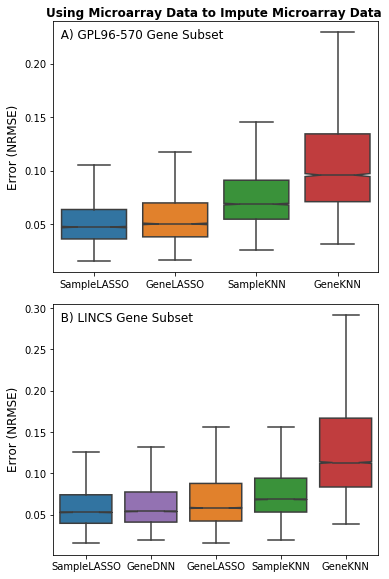

In [7]:
# intialize a dict to store the plot info for the next three cells
plot_info = {}

labels = ['A','B']
fig, ax = plt.subplots(2,1,figsize=(5.5,8))
df_tmp = best_df[(best_df['Train-Data']=='Microarray') & (best_df['Test-Data']=='Microarray')]
df_tmp = df_tmp[df_tmp['Split']=='Tst']
for idx, item in enumerate(['GPL96-570','LINCS']):
    df_tmp2 = df_tmp[df_tmp['GeneSplit']==item]
    df_tmp2 = df_tmp2.replace(to_replace={'Model':{'SampleLasso':'SampleLASSO','GeneLasso':'GeneLASSO'}})
    final_method_order, my_colors, plot_info_dict_tmp =  get_main_figure_info(df_tmp2,best_df_metric,color_dict)
    plot_info['Microarray-Microarray-%s'%item] = plot_info_dict_tmp
    sns.boxplot(data=df_tmp2, x='Model',y='Value',ax=ax[idx],showfliers=False,notch=True,order=final_method_order,
                palette=my_colors )
    ax[idx].set_title('  %s) %s Gene Subset'%(labels[idx],item),loc='left',pad=-18)
    ax[idx].set_ylabel('Error (%s)'%best_df_metric_name,fontsize=12)
    ax[idx].set_xlabel('')
fig.suptitle('Using Microarray Data to Impute Microarray Data',y=1,x=0.55,fontweight='bold')
plt.tight_layout()
save_dir = '../figures/'
fig.savefig(save_dir + 'Fig-MicroMicro-%s-test.pdf'%best_df_metric_name)

# RNAseq-Microarray Figure

Some extra information about plot for Trn-RNAseq and Tst-Microarray and Metric-cvrmse
The median value for SampleLASSO is 0.1439265256974212
The median value for GeneKNN is 0.17166400192052225
The median value for GeneLASSO is 0.19900731832878688
The median value for SampleKNN is 0.26508132620039626
The effect size for SampleLASSO against SampleLASSO is N/A
The effect size for SampleLASSO against GeneKNN is 0.25425503107704817
The effect size for SampleLASSO against GeneLASSO is 0.46748897998867717
The effect size for SampleLASSO against SampleKNN is 0.8811025366730313
The percentage of times SampleLASSO is better than SampleLASSO is N/A
The percentage of times SampleLASSO is better than GeneKNN is 0.7003979533826038
The percentage of times SampleLASSO is better than GeneLASSO is 0.7077885162023877
The percentage of times SampleLASSO is better than SampleKNN is 0.8014023119196513
The effect size for SampleLASSO against SampleLASSO is N/A
The effect size for SampleLASSO against GeneKNN 

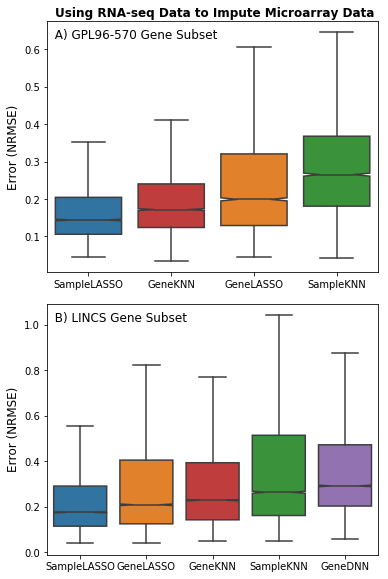

In [8]:
labels = ['A','B']
fig, ax = plt.subplots(2,1,figsize=(5.5,8))
df_tmp = best_df[(best_df['Train-Data']=='RNAseq') & (best_df['Test-Data']=='Microarray')]
df_tmp = df_tmp[df_tmp['Split']=='Tst']
for idx, item in enumerate(['GPL96-570','LINCS']):
    df_tmp2 = df_tmp[df_tmp['GeneSplit']==item]
    df_tmp2 = df_tmp2.replace(to_replace={'Model':{'SampleLasso':'SampleLASSO','GeneLasso':'GeneLASSO'}})
    final_method_order, my_colors, plot_info_dict_tmp =  get_main_figure_info(df_tmp2,best_df_metric,color_dict)
    plot_info['RNAseq-Microarray-%s'%item] = plot_info_dict_tmp
    sns.boxplot(data=df_tmp2, x='Model',y='Value',ax=ax[idx],showfliers=False,notch=True,order=final_method_order,
                palette=my_colors)
    ax[idx].set_title('  %s) %s Gene Subset'%(labels[idx],item),loc='left',pad=-18)
    ax[idx].set_ylabel('Error (%s)'%best_df_metric_name,fontsize=12)
    ax[idx].set_xlabel('')
fig.suptitle('Using RNA-seq Data to Impute Microarray Data',y=1,x=0.55,fontweight='bold')
plt.tight_layout()
save_dir = '../figures/'
fig.savefig(save_dir + 'Fig-RNAseqMicro-%s-test.pdf'%best_df_metric_name)

# RNAseq-RNAseq Figure

Some extra information about plot for Trn-RNAseq and Tst-RNAseq and Metric-cvrmse
The median value for SampleLASSO is 0.8656396985937419
The median value for GeneLASSO is 0.8711575015199767
The median value for SampleKNN is 0.992872505276414
The median value for GeneKNN is 1.1327375679029577
The effect size for SampleLASSO against SampleLASSO is N/A
The effect size for SampleLASSO against GeneLASSO is 0.009166912176709077
The effect size for SampleLASSO against SampleKNN is 0.1978418099556759
The effect size for SampleLASSO against GeneKNN is 0.38797508859081414
The percentage of times SampleLASSO is better than SampleLASSO is N/A
The percentage of times SampleLASSO is better than GeneLASSO is 0.4144400227401933
The percentage of times SampleLASSO is better than SampleKNN is 0.9338639378434717
The percentage of times SampleLASSO is better than GeneKNN is 0.9778283115406481
The effect size for SampleLASSO against SampleLASSO is N/A
The effect size for SampleLASSO against GeneLASSO is 0.

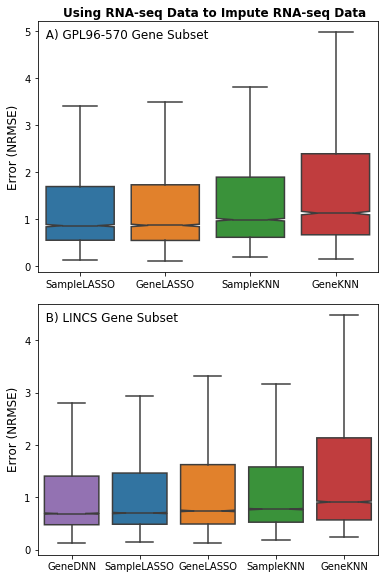

In [9]:
labels = ['A','B']
fig, ax = plt.subplots(2,1,figsize=(5.5,8))
df_tmp = best_df[(best_df['Train-Data']=='RNAseq') & (best_df['Test-Data']=='RNAseq')]
df_tmp = df_tmp[df_tmp['Split']=='Tst']
for idx, item in enumerate(['GPL96-570','LINCS']):
    df_tmp2 = df_tmp[df_tmp['GeneSplit']==item]
    df_tmp2 = df_tmp2.replace(to_replace={'Model':{'SampleLasso':'SampleLASSO','GeneLasso':'GeneLASSO'}})
    final_method_order, my_colors, plot_info_dict_tmp =  get_main_figure_info(df_tmp2,best_df_metric,color_dict)
    plot_info['RNAseq-RNAseq-%s'%item] = plot_info_dict_tmp
    sns.boxplot(data=df_tmp2, x='Model',y='Value',ax=ax[idx],showfliers=False,notch=True,order=final_method_order,
                palette=my_colors)
    ax[idx].set_title('  %s) %s Gene Subset'%(labels[idx],item),loc='left',pad=-18)
    ax[idx].set_ylabel('Error (%s)'%best_df_metric_name,fontsize=12)
    ax[idx].set_xlabel('')
fig.suptitle('Using RNA-seq Data to Impute RNA-seq Data',y=1,x=0.55,fontweight='bold')
plt.tight_layout()
save_dir = '../figures/'
fig.savefig(save_dir + 'FigSM-RNAseqRNAseq-%s-test.pdf'%best_df_metric_name)

# Make a dateframe of plot info

In [10]:
results_tmp = []
for akey in plot_info:
    for amethod in plot_info[akey]:
        median = plot_info[akey][amethod]['Median']
        percent_better = plot_info[akey][amethod]['Percent_Better']
        if isinstance(percent_better, float):
            percent_better = '%.2f'%percent_better 
        effect_size = plot_info[akey][amethod]['Effect_Size']
        if isinstance(effect_size, float):
            effect_size = '%.3f'%effect_size
        pval = plot_info[akey][amethod]['P-Value']
        if isinstance(pval, float):
            pval = '%.2e'%pval
        results_tmp.append([akey,amethod,median,percent_better,effect_size,pval])
col_names = ['Task-Gene-Split','Method','Median','Percent Better','Effect Size','P-Value']
pd.options.display.float_format = '{:,.3f}'.format
dfplot = pd.DataFrame(results_tmp,columns=col_names)

dfplot = dfplot.replace(to_replace={'Method':{'SampleLasso':'SampleLASSO','GeneLasso':'GeneLASSO'}})
dfplot = dfplot.sort_values(by=['Task-Gene-Split','Median'])
dfplot.style.hide_index()

arrays = [dfplot['Task-Gene-Split'].to_numpy(),dfplot['Method'].to_numpy()]
data_ = dfplot[['Median','Percent Better','Effect Size','P-Value']].to_numpy()
dfplot__ = pd.DataFrame(data_, index=arrays,columns=['Median','Percent SL Better','Log2 Effect Size','P-Value'])

dfplot__

Median Percent SL Better  \
Microarray-Microarray-GPL96-570 SampleLASSO  0.047               N/A   
                                GeneLASSO    0.050              0.91   
                                SampleKNN    0.069              1.00   
                                GeneKNN      0.096              1.00   
Microarray-Microarray-LINCS     SampleLASSO  0.053               N/A   
                                GeneDNN      0.054              0.76   
                                GeneLASSO    0.058              0.91   
                                SampleKNN    0.069              0.98   
                                GeneKNN      0.113              1.00   
RNAseq-Microarray-GPL96-570     SampleLASSO  0.144               N/A   
                                GeneKNN      0.172              0.70   
                                GeneLASSO    0.199              0.71   
                                SampleKNN    0.265              0.80   
RNAseq-Microarray-LINCS         SampleLASSO  0.175               N/A   
                                GeneLASSO    0.208              0.62   
                                GeneKNN      0.228              0.84   
                                SampleKNN    0.263              0.76   
                                GeneDNN      0.291              0.77   
RNAseq-RNAseq-GPL96-570         SampleLASSO  0.866               N/A   
                                GeneLASSO    0.871              0.41   
                                SampleKNN    0.993              0.93   
                                GeneKNN      1.133              0.98   
RNAseq-RNAseq-LINCS             GeneDNN      0.693              0.18   
                                SampleLASSO  0.703               N/A   
                                GeneLASSO    0.744              0.62   
                                SampleKNN    0.777              0.84   
                                GeneKNN      0.914              1.00   

                                            Log2 Effect Size    P-Value  
Microarray-Microarray-GPL96-570 SampleLASSO              N/A        N/A  
                                GeneLASSO              0.088   0.00e+00  
                                SampleKNN              0.542   0.00e+00  
                                GeneKNN                1.024   0.00e+00  
Microarray-Microarray-LINCS     SampleLASSO              N/A        N/A  
                                GeneDNN                0.031   0.00e+00  
                                GeneLASSO              0.137   0.00e+00  
                                SampleKNN              0.373   0.00e+00  
                                GeneKNN                1.094   0.00e+00  
RNAseq-Microarray-GPL96-570     SampleLASSO              N/A        N/A  
                                GeneKNN                0.254  4.38e-223  
                                GeneLASSO              0.467  2.21e-299  
                                SampleKNN              0.881   0.00e+00  
RNAseq-Microarray-LINCS         SampleLASSO              N/A        N/A  
                                GeneLASSO              0.251   0.00e+00  
                                GeneKNN                0.384   0.00e+00  
                                SampleKNN              0.589   0.00e+00  
                                GeneDNN                0.734   0.00e+00  
RNAseq-RNAseq-GPL96-570         SampleLASSO              N/A        N/A  
                                GeneLASSO              0.009   6.96e-03  
                                SampleKNN              0.198   0.00e+00  
                                GeneKNN                0.388   0.00e+00  
RNAseq-RNAseq-LINCS             GeneDNN               -0.021   0.00e+00  
                                SampleLASSO              N/A        N/A  
                                GeneLASSO              0.082   0.00e+00  
                                SampleKNN              0.145   0.00e+00  
                             

# Plot the Val and Test set results together

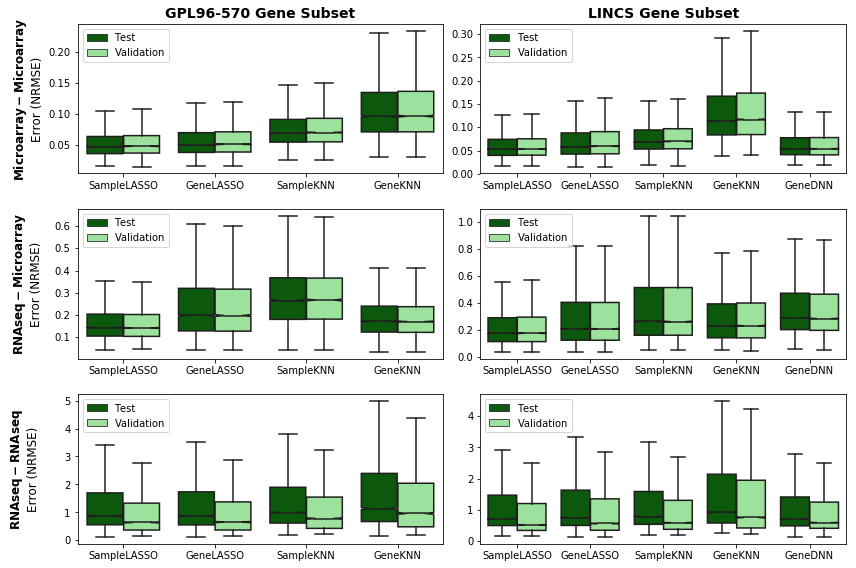

In [11]:
myorder1 = ['SampleLASSO','GeneLASSO','SampleKNN','GeneKNN']
myorder2 = ['SampleLASSO','GeneLASSO','SampleKNN','GeneKNN','GeneDNN']
myorder = [myorder1,myorder2]

fig, ax = plt.subplots(3,2,figsize=(12,8))
for idx2, item2 in enumerate([['Microarray','Microarray'],['RNAseq','Microarray'],['RNAseq','RNAseq']]):
    df_tmp = best_df[(best_df['Train-Data']==item2[0]) & (best_df['Test-Data']==item2[1])]
    for idx, item in enumerate(['GPL96-570','LINCS']):
        df_tmp2 = df_tmp[df_tmp['GeneSplit']==item]
        df_tmp2 = df_tmp2.replace({'Tst':'Test','Val':'Validation'})
        df_tmp2 = df_tmp2.replace(to_replace={'Model':{'SampleLasso':'SampleLASSO','GeneLasso':'GeneLASSO'}})
        sns_ax = sns.boxplot(data=df_tmp2, x='Model',y='Value',hue='Split',ax=ax[idx2,idx],
                    showfliers=False,notch=True,order=myorder[idx],palette=['darkgreen','lightgreen'])
        ax[idx2,idx].set_ylabel('')
        ax[idx2,idx].set_xlabel('')
        ax[idx2,idx].legend(loc=2)

ax[0,0].set_title('GPL96-570 Gene Subset',fontsize=14,fontweight='bold')
ax[0,1].set_title('LINCS Gene Subset',fontsize=14,fontweight='bold')

ax[2,0].set_xticklabels(myorder1)
ax[2,1].set_xticklabels(myorder2)

ax[0,0].set_ylabel(r'$\bf{' + str('Microarray-Microarray') + '}$' + '\nError (%s)'%best_df_metric_name,fontsize=12)
ax[1,0].set_ylabel(r'$\bf{' + str('RNAseq-Microarray') + '}$' + '\nError (%s)'%best_df_metric_name,fontsize=12,
                                                                                labelpad=12)
ax[2,0].set_ylabel(r'$\bf{' + str('RNAseq-RNAseq') + '}$' + '\nError (%s)'%best_df_metric_name,fontsize=12,
                                                                             labelpad=24)

plt.tight_layout()
save_dir = '../figures/'
fig.savefig(save_dir + 'FigSM-valandtest-%s.pdf'%best_df_metric_name)

### Make two SM metric for Microarray to Microarray 

In [12]:
SMmetrics = ['spearman','mae']
SMmetrics_names = ['Spearman','MAE']

Some extra information about plot for Trn-Microarray and Tst-Microarray and Metric-spearman
The median value for SampleLASSO is 0.9042968236385888
The median value for GeneLASSO is 0.89208962432497
The median value for SampleKNN is 0.7916818580713294
The median value for GeneKNN is 0.5946002201824407
The effect size for SampleLASSO against SampleLASSO is N/A
The effect size for SampleLASSO against GeneLASSO is 0.01960773754790583
The effect size for SampleLASSO against SampleKNN is 0.19187560478151142
The effect size for SampleLASSO against GeneKNN is 0.6048763987263157
The percentage of times SampleLASSO is better than SampleLASSO is N/A
The percentage of times SampleLASSO is better than GeneLASSO is 0.8629903354178511
The percentage of times SampleLASSO is better than SampleKNN is 0.9867348872465416
The percentage of times SampleLASSO is better than GeneKNN is 0.9998104983892363
The effect size for SampleLASSO against SampleLASSO is N/A
The effect size for SampleLASSO against GeneLAS

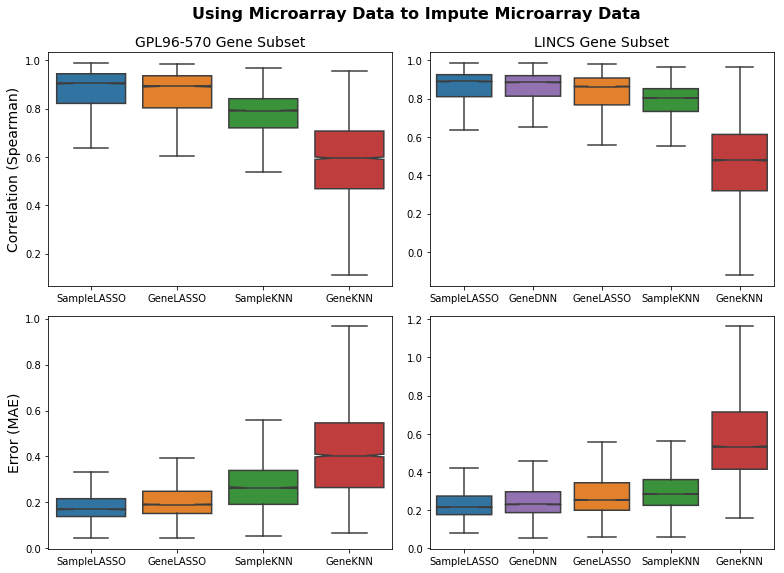

In [13]:
fig, ax = plt.subplots(2,2,figsize=(11,8))
df_tmp = SM_best_df[(SM_best_df['Train-Data']=='Microarray') & (SM_best_df['Test-Data']=='Microarray')]
df_tmp = df_tmp[df_tmp['Split']=='Tst']
for idx2, ametric in enumerate(SMmetrics):
    for idx, item in enumerate(['GPL96-570','LINCS']):
        df_tmp2 = df_tmp[df_tmp['GeneSplit']==item]
        df_tmp2 = df_tmp2[df_tmp2['Metric']==ametric]
        df_tmp2 = df_tmp2.replace(to_replace={'Model':{'SampleLasso':'SampleLASSO','GeneLasso':'GeneLASSO'}})
        final_method_order, my_colors, plot_info_dict_tmp =  get_main_figure_info(df_tmp2,ametric,color_dict)
        sns.boxplot(data=df_tmp2, x='Model',y='Value',ax=ax[idx2,idx],showfliers=False,notch=True,
                    order=final_method_order,palette=my_colors)
        ax[idx2,idx].set_xlabel('')
ax[0,0].set_ylabel('Correlation (%s)'%SMmetrics_names[0],fontsize=14)
ax[1,0].set_ylabel('Error (%s)'%SMmetrics_names[1],fontsize=14)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[0,0].set_title('GPL96-570 Gene Subset',fontsize=14)
ax[0,1].set_title('LINCS Gene Subset',fontsize=14)
plt.tight_layout()
fig.suptitle('Using Microarray Data to Impute Microarray Data',y=0.99,x=0.53,fontsize=16,fontweight='bold')
fig.subplots_adjust(top=0.91)

save_dir = '../figures/'
fig.savefig(save_dir + 'FigSM-MicroMicro-%s-%s-test.pdf'%(SMmetrics_names[0],SMmetrics_names[1]))

### Make two SM metric for RNAseq to RNAseq

Some extra information about plot for Trn-RNAseq and Tst-RNAseq and Metric-spearman
The median value for SampleLASSO is 0.6982828891587084
The median value for GeneLASSO is 0.6958873768191858
The median value for GeneKNN is 0.6654805391199264
The median value for SampleKNN is 0.6570843712558446
The effect size for SampleLASSO against SampleLASSO is N/A
The effect size for SampleLASSO against GeneLASSO is 0.004957783504699654
The effect size for SampleLASSO against GeneKNN is 0.06941514359494441
The effect size for SampleLASSO against SampleKNN is 0.08773299306609714
The percentage of times SampleLASSO is better than SampleLASSO is N/A
The percentage of times SampleLASSO is better than GeneLASSO is 0.4326321773735077
The percentage of times SampleLASSO is better than GeneKNN is 0.5967405722948644
The percentage of times SampleLASSO is better than SampleKNN is 0.6920598825090013
The effect size for SampleLASSO against SampleLASSO is N/A
The effect size for SampleLASSO against GeneLASSO i

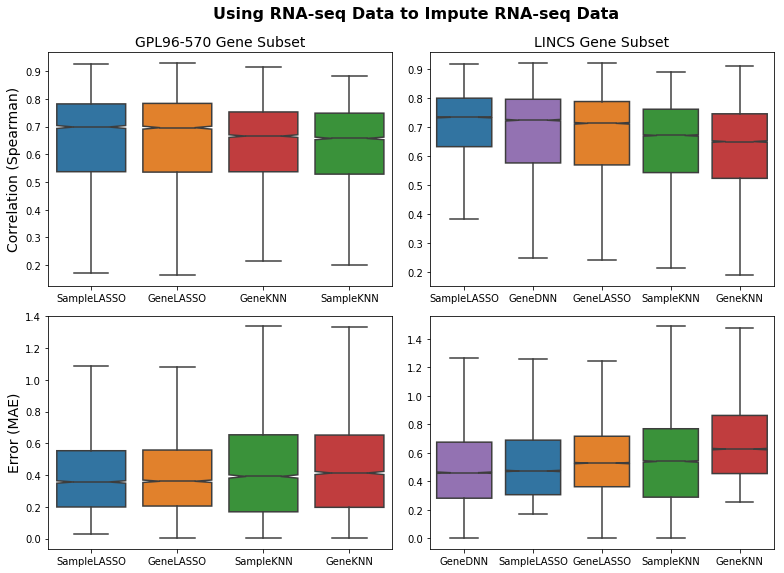

In [14]:
fig, ax = plt.subplots(2,2,figsize=(11,8))
df_tmp = SM_best_df[(SM_best_df['Train-Data']=='RNAseq') & (SM_best_df['Test-Data']=='RNAseq')]
df_tmp = df_tmp[df_tmp['Split']=='Tst']
for idx2, ametric in enumerate(SMmetrics):
    for idx, item in enumerate(['GPL96-570','LINCS']):
        df_tmp2 = df_tmp[df_tmp['GeneSplit']==item]
        df_tmp2 = df_tmp2[df_tmp2['Metric']==ametric]
        df_tmp2 = df_tmp2.replace(to_replace={'Model':{'SampleLasso':'SampleLASSO','GeneLasso':'GeneLASSO'}})
        final_method_order, my_colors, plot_info_dict_tmp =  get_main_figure_info(df_tmp2,ametric,color_dict)
        sns.boxplot(data=df_tmp2, x='Model',y='Value',ax=ax[idx2,idx],showfliers=False,notch=True,
                    order=final_method_order,palette=my_colors)
        ax[idx2,idx].set_xlabel('')
ax[0,0].set_ylabel('Correlation (%s)'%SMmetrics_names[0],fontsize=14)
ax[1,0].set_ylabel('Error (%s)'%SMmetrics_names[1],fontsize=14)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[0,0].set_title('GPL96-570 Gene Subset',fontsize=14)
ax[0,1].set_title('LINCS Gene Subset',fontsize=14)
plt.tight_layout()
fig.suptitle('Using RNA-seq Data to Impute RNA-seq Data',y=0.99,x=0.53,fontsize=16,fontweight='bold')
fig.subplots_adjust(top=0.91)

save_dir = '../figures/'
fig.savefig(save_dir + 'FigSM-RNAseqRNAseq-%s-%s-test.pdf'%(SMmetrics_names[0],SMmetrics_names[1]))

For SampleKNN there were 439 nan values
The nan values were replaced with zero
Some extra information about plot for Trn-RNAseq and Tst-Microarray and Metric-spearman
The median value for SampleLASSO is 0.6392536939715981
The median value for GeneLASSO is 0.6322039781447442
The median value for GeneKNN is 0.47058039842823796
The median value for SampleKNN is 1e-18
The effect size for SampleLASSO against SampleLASSO is N/A
The effect size for SampleLASSO against GeneLASSO is 0.01599847877161044
The effect size for SampleLASSO against GeneKNN is 0.44194736445795135
The effect size for SampleLASSO against SampleKNN is 59.149166205289056
The percentage of times SampleLASSO is better than SampleLASSO is N/A
The percentage of times SampleLASSO is better than GeneLASSO is 0.5641462952435096
The percentage of times SampleLASSO is better than GeneKNN is 0.8025393215842335
The percentage of times SampleLASSO is better than SampleKNN is 0.9946939548986167
The effect size for SampleLASSO against S

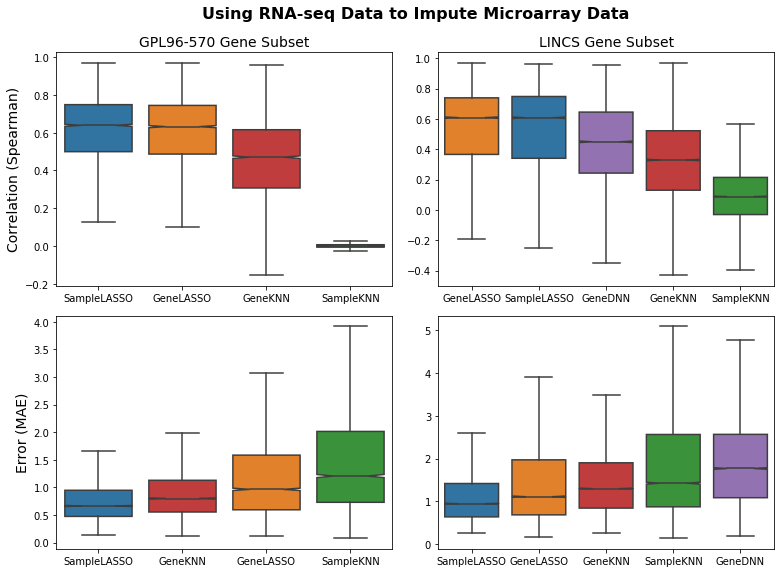

In [15]:
fig, ax = plt.subplots(2,2,figsize=(11,8))
df_tmp = SM_best_df[(SM_best_df['Train-Data']=='RNAseq') & (SM_best_df['Test-Data']=='Microarray')]
df_tmp = df_tmp[df_tmp['Split']=='Tst']
for idx2, ametric in enumerate(SMmetrics):
    for idx, item in enumerate(['GPL96-570','LINCS']):
        df_tmp2 = df_tmp[df_tmp['GeneSplit']==item]
        df_tmp2 = df_tmp2[df_tmp2['Metric']==ametric]
        df_tmp2 = df_tmp2.replace(to_replace={'Model':{'SampleLasso':'SampleLASSO','GeneLasso':'GeneLASSO'}})
        final_method_order, my_colors, plot_info_dict_tmp =  get_main_figure_info(df_tmp2,ametric,color_dict)
        sns.boxplot(data=df_tmp2, x='Model',y='Value',ax=ax[idx2,idx],showfliers=False,notch=True,
                    order=final_method_order,palette=my_colors)
        ax[idx2,idx].set_xlabel('')
ax[0,0].set_ylabel('Correlation (%s)'%SMmetrics_names[0],fontsize=14)
ax[1,0].set_ylabel('Error (%s)'%SMmetrics_names[1],fontsize=14)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[0,0].set_title('GPL96-570 Gene Subset',fontsize=14)
ax[0,1].set_title('LINCS Gene Subset',fontsize=14)
plt.tight_layout()
fig.suptitle('Using RNA-seq Data to Impute Microarray Data',y=0.99,x=0.53,fontsize=16,fontweight='bold')
fig.subplots_adjust(top=0.91)

save_dir = '../figures/'
fig.savefig(save_dir + 'FigSM-RNAseqMicro-%s-%s-test.pdf'%(SMmetrics_names[0],SMmetrics_names[1]))

# Plot the DNN Loss Curves for the Best Models

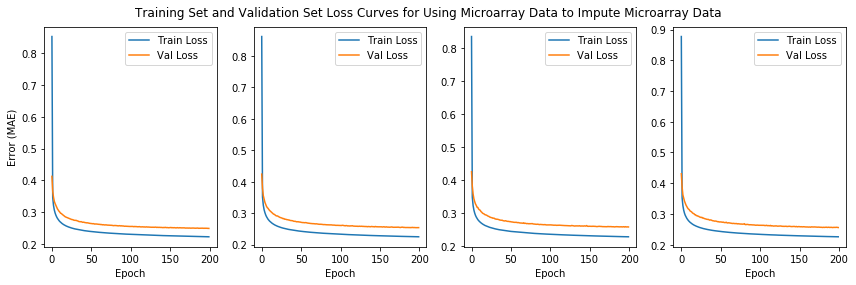

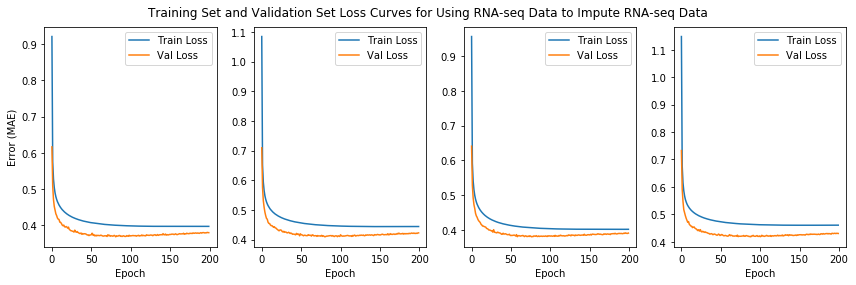

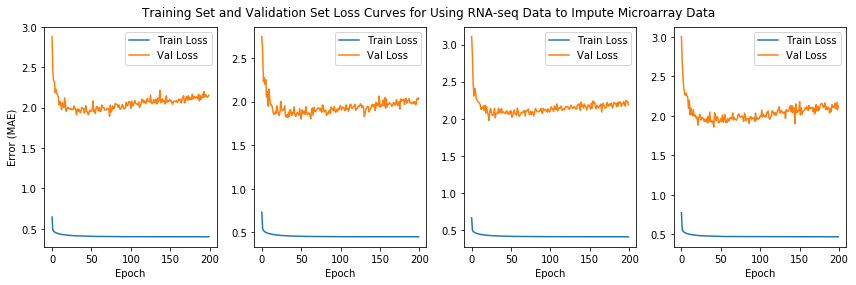

In [16]:
# make Microarray-Microarray figure
fig, ax = plt.subplots(1,4,figsize=(12,4))
df_tmp = DNN_Loss.iloc[:,0:8]
for idx in range(4):
    trn_loss = df_tmp.iloc[:,(2*idx)].to_numpy()
    val_loss = df_tmp.iloc[:,(2*idx)+1].to_numpy()
    ax[idx].plot(trn_loss,label='Train Loss')
    ax[idx].plot(val_loss,label='Val Loss')
    ax[idx].legend()
    ax[idx].set_ylabel('Error (MAE)')
    ax[idx].set_xlabel('Epoch')
    if idx != 0:
        ax[idx].set_ylabel('')
fig.suptitle('Training Set and Validation Set Loss Curves for Using Microarray Data to Impute Microarray Data')
plt.tight_layout()
fig.subplots_adjust(top=0.91)
save_dir = '../figures/'
fig.savefig(save_dir + 'FigSM-DNNLoss-Micro-Micro-test.pdf')

# make RNAseq-RNAseq figure
fig, ax = plt.subplots(1,4,figsize=(12,4))
df_tmp = DNN_Loss.iloc[:,8:16]
for idx in range(4):
    trn_loss = df_tmp.iloc[:,(2*idx)].to_numpy()
    val_loss = df_tmp.iloc[:,(2*idx)+1].to_numpy()
    ax[idx].plot(trn_loss,label='Train Loss')
    ax[idx].plot(val_loss,label='Val Loss')
    ax[idx].legend()
    ax[idx].set_ylabel('Error (MAE)')
    ax[idx].set_xlabel('Epoch')
    if idx != 0:
        ax[idx].set_ylabel('')
fig.suptitle('Training Set and Validation Set Loss Curves for Using RNA-seq Data to Impute RNA-seq Data')
plt.tight_layout()
fig.subplots_adjust(top=0.91)
save_dir = '../figures/'
fig.savefig(save_dir + 'FigSM-DNNLoss-RNAseq-RNAseq-test.pdf')

# make RNAseq-Micro figure
fig, ax = plt.subplots(1,4,figsize=(12,4))
df_tmp = DNN_Loss.iloc[:,16:24]
for idx in range(4):
    trn_loss = df_tmp.iloc[:,(2*idx)].to_numpy()
    val_loss = df_tmp.iloc[:,(2*idx)+1].to_numpy()
    ax[idx].plot(trn_loss,label='Train Loss')
    ax[idx].plot(val_loss,label='Val Loss')
    ax[idx].legend()
    ax[idx].set_ylabel('Error (MAE)')
    ax[idx].set_xlabel('Epoch')
    if idx != 0:
        ax[idx].set_ylabel('')
fig.suptitle('Training Set and Validation Set Loss Curves for Using RNA-seq Data to Impute Microarray Data')
plt.tight_layout()
fig.subplots_adjust(top=0.91)
save_dir = '../figures/'
fig.savefig(save_dir + 'FigSM-DNNLoss-RNAseq-Micro-test.pdf')

# Make Mean and Variance Plots

In [17]:
def get_new_df(TrnData,TstData,GS,method,best_df):
    # get the correct data
    data_dir = '../data/'
    if TstData == 'Microarray':
        data = np.load(data_dir + 'Microarray_Tst_Exp.npy')
    elif TstData == 'RNAseq':
        data = np.load(data_dir + 'RNAseq_Tst_Exp.npy')
        data = np.arcsinh(data)
    else:
        print('Not a go Tst Data value')
        
    # slice the data
    if GS == 'GPL96-570':
        ygenes = np.loadtxt(data_dir + 'GPL96-570_ygenes_inds.txt', dtype=int)
    elif GS == 'LINCS':
        ygenes = np.loadtxt(data_dir + 'LINCS_ygenes_inds.txt', dtype=int)
    data = data[:,ygenes]
    
    # find medians and variance and the inds of the sorted values
    means = np.mean(data,axis=0) # here this is now mean (some point need to change medians to means)
    vars_ = np.var(data,axis=0)
    args_means = np.argsort(means)
    args_vars = np.argsort(vars_)
    
    # subset the dataframe
    df_tmp = best_df[(best_df['Train-Data']==TrnData)]
    df_tmp = df_tmp[(df_tmp['Test-Data']==TstData)]
    df_tmp = df_tmp[(df_tmp['GeneSplit']==GS)]
    df_tmp = df_tmp[df_tmp['Split']=='Tst']
    
    # find the inds for each bin
    if method == 'num_points':
        range_ = len(means)
        bin_size = int(np.rint(range_ / 3))
        bin_edges = [[0,bin_size],[bin_size,2*bin_size],[2*bin_size,len(means)]]

        low_mean = args_means[bin_edges[0][0]:bin_edges[0][1]]
        med_mean = args_means[bin_edges[1][0]:bin_edges[1][1]]
        hgh_mean = args_means[bin_edges[2][0]:bin_edges[2][1]]
        low_var = args_vars[bin_edges[0][0]:bin_edges[0][1]]
        med_var = args_vars[bin_edges[1][0]:bin_edges[1][1]]
        hgh_var = args_vars[bin_edges[2][0]:bin_edges[2][1]]
    elif method == 'values':
        bin_range_mean = (np.max(means) - np.min(means)) / 3
        bin_range_var = (np.max(vars_) - np.min(vars_)) / 3
        bin_edges_mean = [[np.min(means),np.min(means)+bin_range_mean],
                         [np.min(means)+bin_range_mean,np.min(means)+(2*bin_range_mean)],
                         [np.min(means)+(2*bin_range_mean),np.max(means)]]
        bin_edges_var = [[np.min(vars_),np.min(vars_)+bin_range_var],
                         [np.min(vars_)+bin_range_var,np.min(vars_)+(2*bin_range_var)],
                         [np.min(vars_)+(2*bin_range_var),np.max(vars_)]]

        low_mean = np.where((means >= bin_edges_mean[0][0]) & (means < bin_edges_mean[0][1]))[0]
        med_mean = np.where((means >= bin_edges_mean[1][0]) & (means < bin_edges_mean[1][1]))[0]
        hgh_mean = np.where((means >= bin_edges_mean[2][0]) & (means <= bin_edges_mean[2][1]))[0]
        low_var = np.where((vars_ >= bin_edges_var[0][0]) & (vars_ < bin_edges_var[0][1]))[0]
        med_var = np.where((vars_ >= bin_edges_var[1][0]) & (vars_ < bin_edges_var[1][1]))[0]
        hgh_var = np.where((vars_ >= bin_edges_var[2][0]) & (vars_ <= bin_edges_var[2][1]))[0]
    else:
        print('Not a good method')
        
        
    # Add two columns to df_tmp which tells the state of median and variance
    SampNums_list = df_tmp['SampleNum'].tolist()
    mean_col = []
    var_col = []
    for item in SampNums_list:
        if item in low_mean:
            mean_col.append('low')
        elif item in med_mean:
            mean_col.append('med')
        elif item in hgh_mean:
            mean_col.append('hgh')
        else:
            print(item,'is not in any mean set')
        
        if item in low_var:
            var_col.append('low')
        elif item in med_var:
            var_col.append('med')
        elif item in hgh_var:
            var_col.append('hgh')
        else:
            print(item,'is not in any var set')
    
    df_tmp['MedCol'] = mean_col
    df_tmp['VarCol'] = var_col
    
    # This will print some info about the bins
    info = ''
    for item in [[low_mean,'low_mean'], [med_mean,'med_mean'], [hgh_mean,'hgh_mean'],
                [low_var,'low_var'], [med_var,'med_var'], [hgh_var,'hgh_var']]:
        if '_mean' in item[1]:
            vals = means[item[0]]
        elif '_var' in item[1]:
            vals = vars_[item[0]]
        else:
            print('Not a good thing')
        if item[1] == 'low_mean':
            info = info + 'Class, Num_points, Min, Max, Mean\n'
        info = info + '%s, %i, %.3f, %.3f, %.3f\n'%(item[1],len(item[0]),np.min(vals),np.max(vals),np.median(vals))
        
    return df_tmp, info       

('Microarray', 'Microarray', 'GPL96-570', 'num_points', 'cvrmse', 'y-free')
Class, Num_points, Min, Max, Mean
low_mean, 1759, 3.111, 4.743, 4.144
med_mean, 1759, 4.744, 6.120, 5.366
hgh_mean, 1759, 6.120, 12.894, 7.202
low_var, 1759, 0.014, 0.330, 0.183
med_var, 1759, 0.330, 0.753, 0.504
hgh_var, 1759, 0.754, 10.136, 1.209

The number of points in boxplot for panel 0 is 1089
The number of points in boxplot for panel 1 is 394
The number of points in boxplot for panel 2 is 276
The number of points in boxplot for panel 3 is 503
The number of points in boxplot for panel 4 is 645
The number of points in boxplot for panel 5 is 611
The number of points in boxplot for panel 6 is 167
The number of points in boxplot for panel 7 is 720
The number of points in boxplot for panel 8 is 872


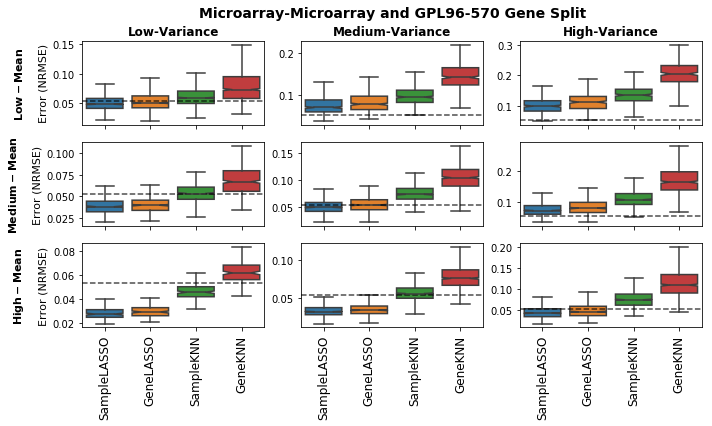

The total number of points in all boxplots is 5277



('Microarray', 'Microarray', 'LINCS', 'num_points', 'cvrmse', 'y-free')
Class, Num_points, Min, Max, Mean
low_mean, 5330, 3.111, 5.206, 4.455
med_mean, 5330, 5.206, 6.836, 5.976
hgh_mean, 5331, 6.838, 13.899, 7.905
low_var, 5330, 0.014, 0.418, 0.248
med_var, 5330, 0.418, 0.888, 0.609
hgh_var, 5331, 0.889, 13.726, 1.500

The number of points in boxplot for panel 0 is 3001
The number of points in boxplot for panel 1 is 1167
The number of points in boxplot for panel 2 is 1162
The number of points in boxplot for panel 3 is 1517
The number of points in boxplot for panel 4 is 1754
The number of points in boxplot for panel 5 is 2059
The number of points in boxplot for panel 6 is 812
The number of points in boxplot for panel 7 is 2409
The number of points in boxplot for panel 8 is 2110


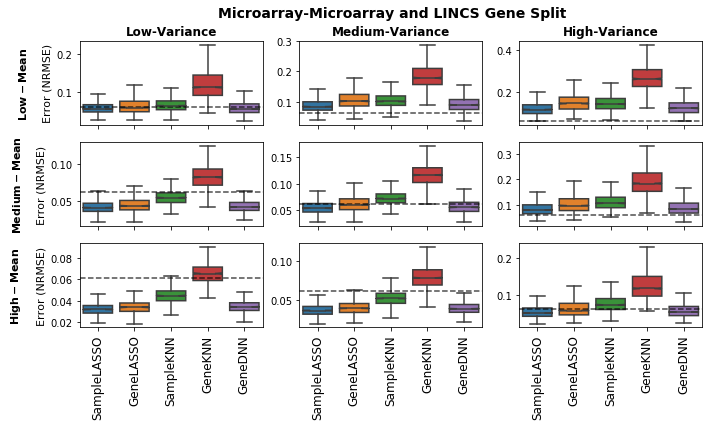

The total number of points in all boxplots is 15991



('RNAseq', 'Microarray', 'GPL96-570', 'num_points', 'cvrmse', 'y-free')
Class, Num_points, Min, Max, Mean
low_mean, 1759, 3.111, 4.743, 4.144
med_mean, 1759, 4.744, 6.120, 5.366
hgh_mean, 1759, 6.120, 12.894, 7.202
low_var, 1759, 0.014, 0.330, 0.183
med_var, 1759, 0.330, 0.753, 0.504
hgh_var, 1759, 0.754, 10.136, 1.209

The number of points in boxplot for panel 0 is 1089
The number of points in boxplot for panel 1 is 394
The number of points in boxplot for panel 2 is 276
The number of points in boxplot for panel 3 is 503
The number of points in boxplot for panel 4 is 645
The number of points in boxplot for panel 5 is 611
The number of points in boxplot for panel 6 is 167
The number of points in boxplot for panel 7 is 720
The number of points in boxplot for panel 8 is 872


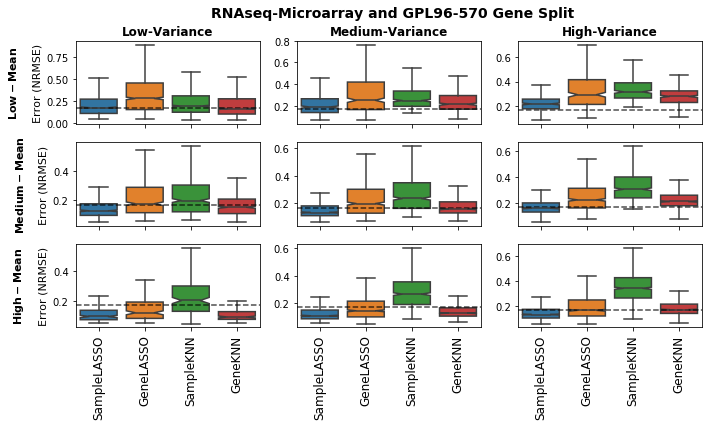

The total number of points in all boxplots is 5277



('RNAseq', 'Microarray', 'LINCS', 'num_points', 'cvrmse', 'y-free')
Class, Num_points, Min, Max, Mean
low_mean, 5330, 3.111, 5.206, 4.455
med_mean, 5330, 5.206, 6.836, 5.976
hgh_mean, 5331, 6.838, 13.899, 7.905
low_var, 5330, 0.014, 0.418, 0.248
med_var, 5330, 0.418, 0.888, 0.609
hgh_var, 5331, 0.889, 13.726, 1.500

The number of points in boxplot for panel 0 is 3001
The number of points in boxplot for panel 1 is 1167
The number of points in boxplot for panel 2 is 1162
The number of points in boxplot for panel 3 is 1517
The number of points in boxplot for panel 4 is 1754
The number of points in boxplot for panel 5 is 2059
The number of points in boxplot for panel 6 is 812
The number of points in boxplot for panel 7 is 2409
The number of points in boxplot for panel 8 is 2110


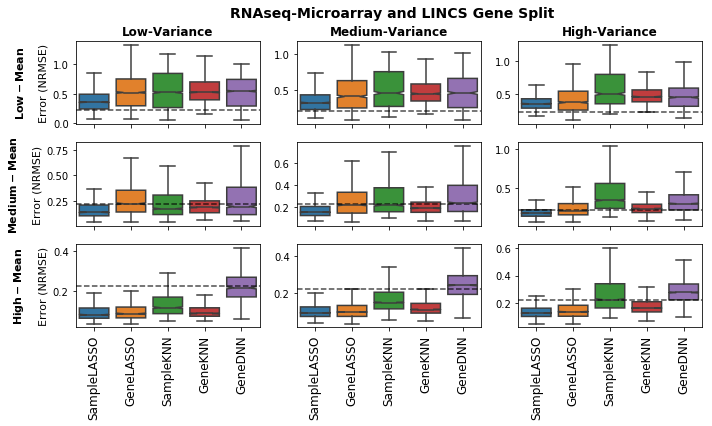

The total number of points in all boxplots is 15991



('RNAseq', 'RNAseq', 'GPL96-570', 'num_points', 'cvrmse', 'y-free')
Class, Num_points, Min, Max, Mean
low_mean, 1759, 0.001, 0.350, 0.129
med_mean, 1759, 0.350, 1.236, 0.712
hgh_mean, 1759, 1.236, 7.406, 1.899
low_var, 1759, 0.001, 0.635, 0.234
med_var, 1759, 0.635, 1.921, 1.220
hgh_var, 1759, 1.922, 8.530, 2.807

The number of points in boxplot for panel 0 is 1627
The number of points in boxplot for panel 1 is 132
The number of points in boxplot for panel 2 is 0
The number of points in boxplot for panel 3 is 132
The number of points in boxplot for panel 4 is 1425
The number of points in boxplot for panel 5 is 202
The number of points in boxplot for panel 6 is 0
The number of points in boxplot for panel 7 is 202
The number of points in boxplot for panel 8 is 1557


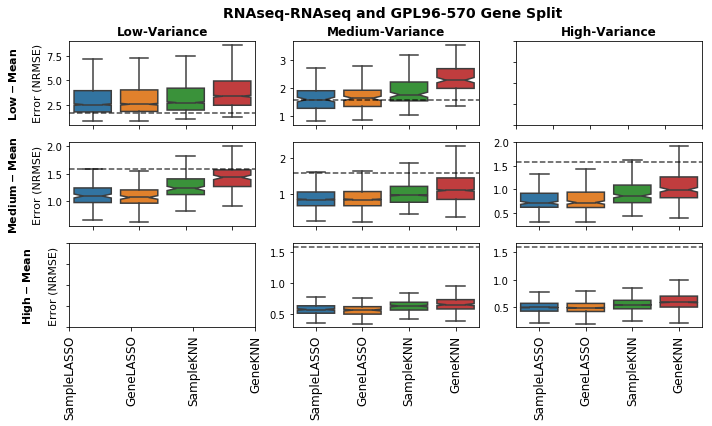

The total number of points in all boxplots is 5277



('RNAseq', 'RNAseq', 'LINCS', 'num_points', 'cvrmse', 'y-free')
Class, Num_points, Min, Max, Mean
low_mean, 5330, 0.001, 0.588, 0.221
med_mean, 5330, 0.588, 1.693, 1.124
hgh_mean, 5331, 1.694, 8.792, 2.427
low_var, 5330, 0.000, 1.141, 0.429
med_var, 5330, 1.141, 2.685, 1.937
hgh_var, 5331, 2.685, 13.852, 3.530

The number of points in boxplot for panel 0 is 4854
The number of points in boxplot for panel 1 is 470
The number of points in boxplot for panel 2 is 6
The number of points in boxplot for panel 3 is 476
The number of points in boxplot for panel 4 is 3928
The number of points in boxplot for panel 5 is 926
The number of points in boxplot for panel 6 is 0
The number of points in boxplot for panel 7 is 932
The number of points in boxplot for panel 8 is 4399


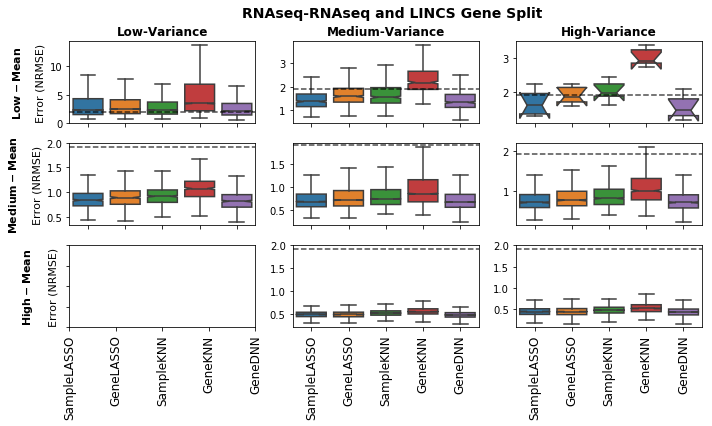

The total number of points in all boxplots is 15991





In [18]:
param_sets = [('Microarray','Microarray','GPL96-570','num_points',best_df_metric,'y-free'),
              ('Microarray','Microarray','LINCS','num_points',best_df_metric,'y-free'),
              ('RNAseq','Microarray','GPL96-570','num_points',best_df_metric,'y-free'),
              ('RNAseq','Microarray','LINCS','num_points',best_df_metric,'y-free'),
              ('RNAseq','RNAseq','GPL96-570','num_points',best_df_metric,'y-free'),
              ('RNAseq','RNAseq','LINCS','num_points',best_df_metric,'y-free')]


for plot_params in param_sets:
    myorder1 = ['SampleLASSO','GeneLASSO','SampleKNN','GeneKNN']
    myorder2 = ['SampleLASSO','GeneLASSO','SampleKNN','GeneKNN','GeneDNN']
    df_tmp, info = get_new_df(plot_params[0],plot_params[1],plot_params[2],plot_params[3],best_df)
    SLmed = np.mean(df_tmp[df_tmp['Model']=='SampleLasso']['Value'].to_numpy())
    print(plot_params)
    print(info)
    if plot_params[5] == 'y-free':
        fig, ax = plt.subplots(3,3,figsize=(10,6),sharey=False)
    elif plot_params[5] == 'y-not-free':
        fig, ax = plt.subplots(3,3,figsize=(10,6),sharey=True)
    else:
        print('Something is different')
    axs = ax.ravel()
    total_points = 0
    for idx, med_var in enumerate([['low','low'],['low','med'],['low','hgh'],
                    ['med','low'],['med','med'],['med','hgh'],
                    ['hgh','low'],['hgh','med'],['hgh','hgh']]):
        df_tmp2 = df_tmp[(df_tmp['MedCol']==med_var[0]) & (df_tmp['VarCol']==med_var[1])]
        df_tmp2 = df_tmp2.replace(to_replace={'Model':{'SampleLasso':'SampleLASSO','GeneLasso':'GeneLASSO'}})
        if plot_params[2] == 'GPL96-570':
            num_rows = int(df_tmp2.shape[0]/4)
            myorder = myorder1
        elif plot_params[2] == 'LINCS':
            num_rows = int(df_tmp2.shape[0]/5)
            myorder = myorder2
        print('The number of points in boxplot for panel %i is %i'%(idx,num_rows))
        total_points = total_points + num_rows
        if df_tmp2.shape[0] != 0:
            sns.boxplot(data=df_tmp2,x='Model',y='Value',ax=axs[idx],showfliers=False,notch=True,order=myorder)
            axs[idx].axhline(SLmed,alpha=0.7,c='k',ls='--')
            good_xticks = axs[idx].get_xticks()
        else:
            axs[idx].set_yticklabels('')
        axs[idx].set_xticklabels('')
        axs[idx].set_ylabel('')
        axs[idx].set_xlabel('')
    
    for idx_tmp in [6,7,8]:
        axs[idx_tmp].set_xticks(good_xticks)
        axs[idx_tmp].set_xticklabels(myorder,rotation=90, fontsize=12)
    axs[0].set_title('Low-Variance',fontsize=12,fontweight='bold')
    axs[1].set_title('Medium-Variance',fontsize=12,fontweight='bold')
    axs[2].set_title('High-Variance',fontsize=12,fontweight='bold')
    axs[0].set_ylabel(r'$\bf{' + str('Low-Mean') + '}$' + '\n\nError (%s)'%best_df_metric_name,fontsize=11)
    axs[3].set_ylabel(r'$\bf{' + str('Medium-Mean') + '}$' + '\n\nError (%s)'%best_df_metric_name,fontsize=11)
    axs[6].set_ylabel(r'$\bf{' + str('High-Mean') + '}$' + '\n\nError (%s)'%best_df_metric_name,fontsize=11)
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.2,top=0.9)
    fig.suptitle('%s-%s and %s Gene Split'%(plot_params[0],plot_params[1],plot_params[2]),
                 fontweight='bold',fontsize=14,x=0.55)
    plt.show()
    print('The total number of points in all boxplots is',total_points)
    print('\n\n')
    save_dir = '../figures/'
    fig.savefig(save_dir + 'FigSM-MeanandVar-%s-%s-%s-%s-%s-%s.pdf'%plot_params)

# Make plots for the beta analysis

In [19]:
# load some data needed for plots
data_dir = '../data/'
df_tiss_labels = pd.read_csv(data_dir + 'Beta_GSM_Labels.tsv', sep='\t')
#Get the list of tissues
all_tissues = df_tiss_labels['Tissue'].unique()
df_key = pd.read_csv(data_dir + 'Microarray_Trn_Key.tsv', sep='\t')

### Make heatmap

The shape of the heatmap is (222, 6)


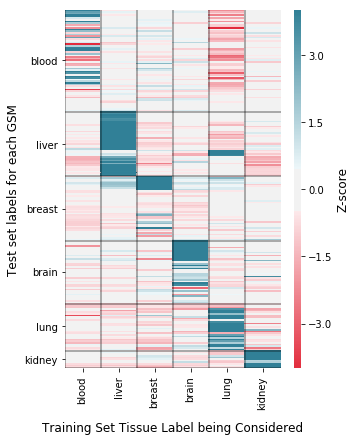

In [20]:
fig, ax = plt.subplots(figsize=(5,6))
mycmap = sns.diverging_palette(10, 220, sep=30, n=7, s=85, as_cmap=True)
ax_hm = sns.heatmap(results_data,cmap=mycmap,fmt='s',ax=ax,annot_kws={"size": 10},vmin=-4,vmax=4,
           cbar_kws={'label': 'Z-score','aspect':50})
ax.set_xticklabels(all_tissues, fontsize=14,rotation=90)
ax.set_yticks([],[])
plt.tight_layout()
print('The shape of the heatmap is', results_data.shape)
start_idx = 0
yticks_pos = []
for idx, atiss in enumerate(all_tissues):
    num_samps = df_tiss_labels[(df_tiss_labels['Split']=='tst') & (df_tiss_labels['Tissue']==atiss)].shape[0]
    ax.axhline(start_idx + num_samps, c='k',alpha=0.4)
    ax.axvline(idx,c='k',alpha=0.4)
    yticks_pos.append(int(start_idx + (num_samps/2)))
    start_idx = start_idx + num_samps
ax.set_yticks(yticks_pos,[])
ax.set_yticklabels(all_tissues,fontsize=10)
ax.set_xticklabels(all_tissues,fontsize=10)
ax.set_xlabel('Training Set Tissue Label being Considered',fontsize=12,labelpad=12)
ax.set_ylabel('Test set labels for each GSM',fontsize=12)
ax_hm.figure.axes[-1].yaxis.label.set_size(12)
ax_hm.figure.axes[-1].tick_params(labelsize=10)
fig.subplots_adjust(left=0.18,bottom=0.15,right=0.93,top=0.98)
tmp_data_dir = '../figures/'
fig.savefig(tmp_data_dir + 'Fig-Beta-Analysis-Heatmap.pdf')

### Make boxplot

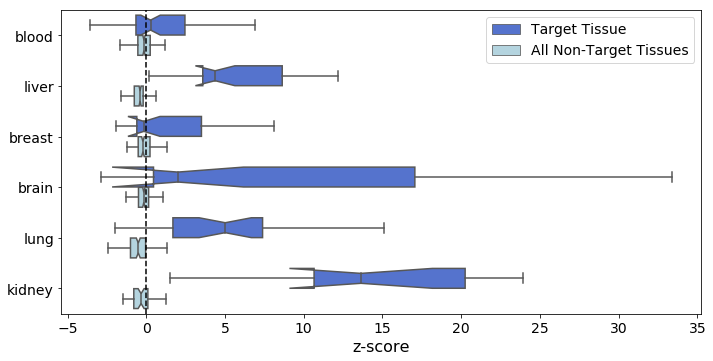

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=results_boxplot_df,y='Tissue',x='z-score',hue='Target?',showfliers=False,notch=True,
            palette=['royalblue','lightblue'])
plt.tight_layout()
ax.xaxis.label.set_size(16)
ax.axvline(0,c='k',ls='--')
ax.set_ylabel('')
ax.legend(loc=1,fontsize=14)
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
tmp_data_dir = '../figures/'
fig.savefig(tmp_data_dir + 'FigSM-Beta-Analysis-Boxplots.pdf')

### Make the dataframe of how many GSM/GSES for each tissue

In [22]:
count_results = []
for atissue in all_tissues:
    num_GSMs_list = []
    num_GSEs_list = []
    for asplit in ['tst','trn']:
        tmp_GSMs = df_tiss_labels[(df_tiss_labels['Tissue']==atissue) & (df_tiss_labels['Split']==asplit)]['GSM'].tolist()
        df_key_tmp = df_key[df_key['GSM'].isin(tmp_GSMs)]
        num_GSMs = len(df_key_tmp['GSM'].unique())
        num_GSEs = len(df_key_tmp['Original_GSE'].unique())
        num_GSMs_list.append(num_GSMs)
        num_GSEs_list.append(num_GSEs)
    count_results.append([atissue,num_GSMs_list[0],num_GSEs_list[0],num_GSMs_list[1],num_GSEs_list[1]])
    
col_names = ['Tissue','Number GSMs (Train)','Number GSEs (Train)','Number GSMs (Test)','Number GSEs (Test)' ]

df_count = pd.DataFrame(count_results, columns=col_names)
df_count

,Tissue,Number GSMs (Train),Number GSEs (Train),Number GSMs (Test),Number GSEs (Test)
0,blood,63,5,1197,33
1,liver,40,6,776,27
2,breast,40,6,770,25
3,brain,39,3,752,19
4,lung,29,6,662,10
5,kidney,11,3,240,6
